## 1. Setup and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt


torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


### 1.1 Hyperparameters & Paths

In [4]:
IMG_SIZE      = 150
NUM_CLASSES   = 11           # Food-11 dataset
EPOCHS        = 50
LEARNING_RATES = [1e-3, 5e-4, 1e-4]
BATCH_SIZES    = [32, 64]
WEIGHT_DECAY   = 5e-5

DATA_DIR = '/content/drive/MyDrive/food11'

### 1.2 TRACKING

In [5]:
history              = {}  # {(model, bs, lr): {'train_losses',...,'val_accs'}}
best_cfg             = {}  # filled below for no‐dropout
results_no_dropout   = {}
results_with_dropout = {}

## 2. Data Preparation

In [6]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        scale=(0.8, 1.0),
        fill=0
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])




def get_loaders(bs):
    train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"),      transform=train_tf)
    val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "validation"), transform=val_tf)
    test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),       transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader

## 3. Model Definitions

### 3.1 Plain CNN

In [7]:
class PlainCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, img_size=IMG_SIZE, dropout_prob=0.0):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,128,5), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,64,3), nn.BatchNorm2d(64),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,32,3),  nn.BatchNorm2d(32),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,32,3),  nn.BatchNorm2d(32),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,16,3),  nn.BatchNorm2d(16),  nn.ReLU(), nn.MaxPool2d(2),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            n_flat = self.features(dummy).view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flat, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

### 3.2 Residual Block & ResCNN

In [8]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class ResCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, img_size=IMG_SIZE, dropout_prob=0.0):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(3,128,5), nn.BatchNorm2d(128),
                                    nn.ReLU(), nn.MaxPool2d(2))
        self.block2 = nn.Sequential(nn.Conv2d(128,64,3), nn.BatchNorm2d(64),
                                    nn.ReLU(), nn.MaxPool2d(2))
        self.block3 = nn.Sequential(nn.Conv2d(64,32,3),  nn.BatchNorm2d(32),
                                    nn.ReLU(), nn.MaxPool2d(2))
        self.conv4  = nn.Sequential(nn.Conv2d(32,32,3,padding=1),
                                    nn.BatchNorm2d(32), nn.ReLU())
        self.res4   = ResBlock(32)
        self.pool4  = nn.MaxPool2d(2)
        self.block5 = nn.Sequential(nn.Conv2d(32,16,3), nn.BatchNorm2d(16),
                                    nn.ReLU(), nn.MaxPool2d(2))

        with torch.no_grad():
            dummy = torch.zeros(1,3,img_size,img_size)
            x = self.block1(dummy)
            x = self.block2(x)
            x = self.block3(x)
            x = self.pool4(self.res4(self.conv4(x)))
            x = self.block5(x)
            n_flat = x.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flat, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool4(self.res4(self.conv4(x)))
        x = self.block5(x)
        return self.classifier(x)

## 4. Training & Evaluation Functions

In [10]:
def compute_accuracy(logits, labels):
    return (logits.argmax(1)==labels).float().mean().item()

def train_epoch(m, loader, crit, opt):
    m.train()
    L, A = 0.0, 0.0
    for imgs, labs in tqdm(loader, leave=False):
        imgs, labs = imgs.to(device), labs.to(device)
        opt.zero_grad()
        out = m(imgs)
        loss = crit(out, labs)
        loss.backward(); opt.step()
        L += loss.item()*imgs.size(0)
        A += compute_accuracy(out,labs)*imgs.size(0)
    n = len(loader.dataset)
    return L/n, A/n

def eval_epoch(m, loader, crit):
    m.eval()
    L, A = 0.0, 0.0
    with torch.no_grad():
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            out = m(imgs)
            loss = crit(out, labs)
            L += loss.item()*imgs.size(0)
            A += compute_accuracy(out,labs)*imgs.size(0)
    n = len(loader.dataset)
    return L/n, A/n

def plot_confusion(m, loader, classes):
    m.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            p  = m(x).argmax(1).cpu().numpy()
            preds.extend(p); trues.extend(y.numpy())
    cm = confusion_matrix(trues,preds)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks,classes,rotation=45)
    plt.yticks(ticks,classes)
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# 5. Phase 1: Hyperparameter Sweep (no dropout) → pick best model
# -----------------------------------------------------------------------------

In [10]:
model_map = {'PlainCNN':PlainCNN, 'ResCNN':ResCNN}
for name in model_map:
    best_cfg[name] = {'val_acc':0.0}

for model_name, Model in model_map.items():
    for bs in BATCH_SIZES:
        tr, va, _ = get_loaders(bs)
        for lr in LEARNING_RATES:
            print(f"\n▶ {model_name} | BS={bs} | LR={lr}")
            m     = Model(dropout_prob=0.0).to(device)
            crit  = nn.CrossEntropyLoss()
            opt   = optim.Adam(m.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
            sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min',
                                                        factor=np.sqrt(0.1), patience=5, min_lr=1e-6)
            # record
            tr_L, tr_A, va_L, va_A = [], [], [], []
            best_w, best_a = copy.deepcopy(m.state_dict()), 0.0

            for ep in range(1, EPOCHS+1):
                ltr, atr = train_epoch(m, tr, crit, opt)
                lva, ava = eval_epoch(m, va, crit)
                sched.step(lva)
                tr_L.append(ltr); tr_A.append(atr)
                va_L.append(lva); va_A.append(ava)
                if ava>best_a:
                    best_a, best_w = ava, copy.deepcopy(m.state_dict())
                if ep==1 or ep%10==0:
                    print(f"  Ep{ep:02d} ― tr_acc={atr:.4f} | val_acc={ava:.4f}")

            history[(model_name,bs,lr)] = {
                'train_losses':tr_L, 'train_accs':tr_A,
                'val_losses':va_L,   'val_accs':va_A
            }
            if best_a>best_cfg[model_name]['val_acc']:
                best_cfg[model_name].update({
                    'val_acc':    best_a,
                    'bs':         bs,
                    'lr':         lr,
                    'state_dict':best_w
                })


▶ PlainCNN | BS=32 | LR=0.001


  Ep01 ― tr_acc=0.1486 | val_acc=0.1891


  Ep10 ― tr_acc=0.3764 | val_acc=0.3673


  Ep20 ― tr_acc=0.4591 | val_acc=0.4582


  Ep30 ― tr_acc=0.5177 | val_acc=0.5200


  Ep40 ― tr_acc=0.5627 | val_acc=0.5600


  Ep50 ― tr_acc=0.6491 | val_acc=0.6655

▶ PlainCNN | BS=32 | LR=0.0005


  Ep01 ― tr_acc=0.1600 | val_acc=0.1818


  Ep10 ― tr_acc=0.3759 | val_acc=0.4036


  Ep20 ― tr_acc=0.4495 | val_acc=0.4655


  Ep30 ― tr_acc=0.5255 | val_acc=0.5236


  Ep40 ― tr_acc=0.5482 | val_acc=0.6218


  Ep50 ― tr_acc=0.6018 | val_acc=0.5745

▶ PlainCNN | BS=32 | LR=0.0001


  Ep01 ― tr_acc=0.1368 | val_acc=0.1491


  Ep10 ― tr_acc=0.3218 | val_acc=0.3709


  Ep20 ― tr_acc=0.3955 | val_acc=0.4036


  Ep30 ― tr_acc=0.4573 | val_acc=0.4255


  Ep40 ― tr_acc=0.4932 | val_acc=0.4764


  Ep50 ― tr_acc=0.5159 | val_acc=0.5600

▶ PlainCNN | BS=64 | LR=0.001


  Ep01 ― tr_acc=0.1455 | val_acc=0.1782


  Ep10 ― tr_acc=0.3641 | val_acc=0.3636


  Ep20 ― tr_acc=0.4373 | val_acc=0.4727


  Ep30 ― tr_acc=0.5086 | val_acc=0.5091


  Ep40 ― tr_acc=0.5573 | val_acc=0.4291


  Ep50 ― tr_acc=0.6268 | val_acc=0.6255

▶ PlainCNN | BS=64 | LR=0.0005


  Ep01 ― tr_acc=0.1545 | val_acc=0.1709


  Ep10 ― tr_acc=0.3718 | val_acc=0.3564


  Ep20 ― tr_acc=0.4632 | val_acc=0.4473


  Ep30 ― tr_acc=0.5455 | val_acc=0.5891


  Ep40 ― tr_acc=0.5850 | val_acc=0.6291


  Ep50 ― tr_acc=0.5850 | val_acc=0.6182

▶ PlainCNN | BS=64 | LR=0.0001


  Ep01 ― tr_acc=0.1036 | val_acc=0.1236


  Ep10 ― tr_acc=0.3073 | val_acc=0.2945


  Ep20 ― tr_acc=0.3864 | val_acc=0.3964


  Ep30 ― tr_acc=0.4327 | val_acc=0.4800


  Ep40 ― tr_acc=0.4823 | val_acc=0.5018


  Ep50 ― tr_acc=0.5086 | val_acc=0.4800

▶ ResCNN | BS=32 | LR=0.001


  Ep01 ― tr_acc=0.1545 | val_acc=0.2255


  Ep10 ― tr_acc=0.3968 | val_acc=0.3709


  Ep20 ― tr_acc=0.4659 | val_acc=0.4073


  Ep30 ― tr_acc=0.5855 | val_acc=0.6073


  Ep40 ― tr_acc=0.6577 | val_acc=0.5927


  Ep50 ― tr_acc=0.6991 | val_acc=0.6509

▶ ResCNN | BS=32 | LR=0.0005


  Ep01 ― tr_acc=0.1368 | val_acc=0.1600


  Ep10 ― tr_acc=0.3818 | val_acc=0.4800


  Ep20 ― tr_acc=0.5005 | val_acc=0.5200


  Ep30 ― tr_acc=0.5936 | val_acc=0.5491


  Ep40 ― tr_acc=0.6655 | val_acc=0.6618


  Ep50 ― tr_acc=0.7205 | val_acc=0.6873

▶ ResCNN | BS=32 | LR=0.0001


  Ep01 ― tr_acc=0.1236 | val_acc=0.1964


  Ep10 ― tr_acc=0.3200 | val_acc=0.3491


  Ep20 ― tr_acc=0.4300 | val_acc=0.4800


  Ep30 ― tr_acc=0.5032 | val_acc=0.5273


  Ep40 ― tr_acc=0.5482 | val_acc=0.5745


  Ep50 ― tr_acc=0.5723 | val_acc=0.5855

▶ ResCNN | BS=64 | LR=0.001


  Ep01 ― tr_acc=0.1459 | val_acc=0.1745


  Ep10 ― tr_acc=0.3750 | val_acc=0.3309


  Ep20 ― tr_acc=0.4714 | val_acc=0.4509


  Ep30 ― tr_acc=0.5977 | val_acc=0.5927


  Ep40 ― tr_acc=0.6518 | val_acc=0.6145


  Ep50 ― tr_acc=0.7200 | val_acc=0.6873

▶ ResCNN | BS=64 | LR=0.0005


  Ep01 ― tr_acc=0.1314 | val_acc=0.1855


  Ep10 ― tr_acc=0.3914 | val_acc=0.4291


  Ep20 ― tr_acc=0.5241 | val_acc=0.5673


  Ep30 ― tr_acc=0.5782 | val_acc=0.5782


  Ep40 ― tr_acc=0.6118 | val_acc=0.5964


  Ep50 ― tr_acc=0.6727 | val_acc=0.6545

▶ ResCNN | BS=64 | LR=0.0001


  Ep01 ― tr_acc=0.1182 | val_acc=0.1745


  Ep10 ― tr_acc=0.3191 | val_acc=0.3273


  Ep20 ― tr_acc=0.4105 | val_acc=0.4145


  Ep30 ― tr_acc=0.4641 | val_acc=0.5127


  Ep40 ― tr_acc=0.5209 | val_acc=0.5636


  Ep50 ― tr_acc=0.5736 | val_acc=0.5927


# -----------------------------------------------------------------------------
# 6. Phase 1: Final test of the best model (no dropout)
# -----------------------------------------------------------------------------

In [11]:
for name in model_map:
    cfg = best_cfg[name]
    _,_,test = get_loaders(cfg['bs'])
    m = model_map[name](dropout_prob=0.0).to(device)
    m.load_state_dict(cfg['state_dict'])
    _, ta = eval_epoch(m, test, nn.CrossEntropyLoss())
    print(f"\n✅ {name} | val_acc={cfg['val_acc']:.4f} | test_acc={ta:.4f}")
    results_no_dropout[name] = {
        'val_acc': cfg['val_acc'],
        'test_acc':ta,
        'state_dict':cfg['state_dict']
    }



✅ PlainCNN | val_acc=0.6655 | test_acc=0.5382

✅ ResCNN | val_acc=0.6982 | test_acc=0.5818


# -----------------------------------------------------------------------------
# 7. Phase 2: Retrain & evaluate with dropout
# -----------------------------------------------------------------------------

In [12]:
for name in model_map:
    cfg = best_cfg[name]
    tr, va, te = get_loaders(cfg['bs'])
    for p in [0.3,0.5]:
        print(f"\n▶ {name} retrain with dropout={p}")
        m    = model_map[name](dropout_prob=p).to(device)
        crit = nn.CrossEntropyLoss()
        opt  = optim.Adam(m.parameters(), lr=cfg['lr'], weight_decay=WEIGHT_DECAY)
        sched= optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min',
                                                   factor=np.sqrt(0.1), patience=5, min_lr=1e-6)
        best_w, best_a = copy.deepcopy(m.state_dict()), 0.0

        for ep in range(1,EPOCHS+1):
            _, _  = train_epoch(m, tr, crit, opt)
            _, ava= eval_epoch(m, va, crit)
            sched.step(ava)
            if ava>best_a:
                best_a, best_w = ava, copy.deepcopy(m.state_dict())
            if ep==1 or ep%10==0:
                print(f"  Ep{ep:02d} ― val_acc={ava:.4f}")

        m.load_state_dict(best_w)
        _, ta = eval_epoch(m, te, nn.CrossEntropyLoss())
        print(f"   → best val_acc={best_a:.4f} | test_acc={ta:.4f}")
        results_with_dropout.setdefault(name, {})[p] = {
            'val_acc':    best_a,
            'test_acc':   ta,
            'state_dict': best_w
        }



▶ PlainCNN retrain with dropout=0.3


  Ep01 ― val_acc=0.1927


  Ep10 ― val_acc=0.3818


  Ep20 ― val_acc=0.5018


  Ep30 ― val_acc=0.5236


  Ep40 ― val_acc=0.5127


  Ep50 ― val_acc=0.5164
   → best val_acc=0.5236 | test_acc=0.4400

▶ PlainCNN retrain with dropout=0.5


  Ep01 ― val_acc=0.1709


  Ep10 ― val_acc=0.3818


  Ep20 ― val_acc=0.4582


  Ep30 ― val_acc=0.4800


  Ep40 ― val_acc=0.4764


  Ep50 ― val_acc=0.4618
   → best val_acc=0.4909 | test_acc=0.4618

▶ ResCNN retrain with dropout=0.3


  Ep01 ― val_acc=0.1673


  Ep10 ― val_acc=0.4436


  Ep20 ― val_acc=0.5091


  Ep30 ― val_acc=0.5164


  Ep40 ― val_acc=0.5382


  Ep50 ― val_acc=0.5345
   → best val_acc=0.5418 | test_acc=0.4800

▶ ResCNN retrain with dropout=0.5


  Ep01 ― val_acc=0.1564


  Ep10 ― val_acc=0.3491


  Ep20 ― val_acc=0.4255


  Ep30 ― val_acc=0.4182


  Ep40 ― val_acc=0.4400


  Ep50 ― val_acc=0.4327
   → best val_acc=0.4400 | test_acc=0.4218


### 8. PLOT #1: BEST VAL-ACC vs LR (all 4 curves in one graph)

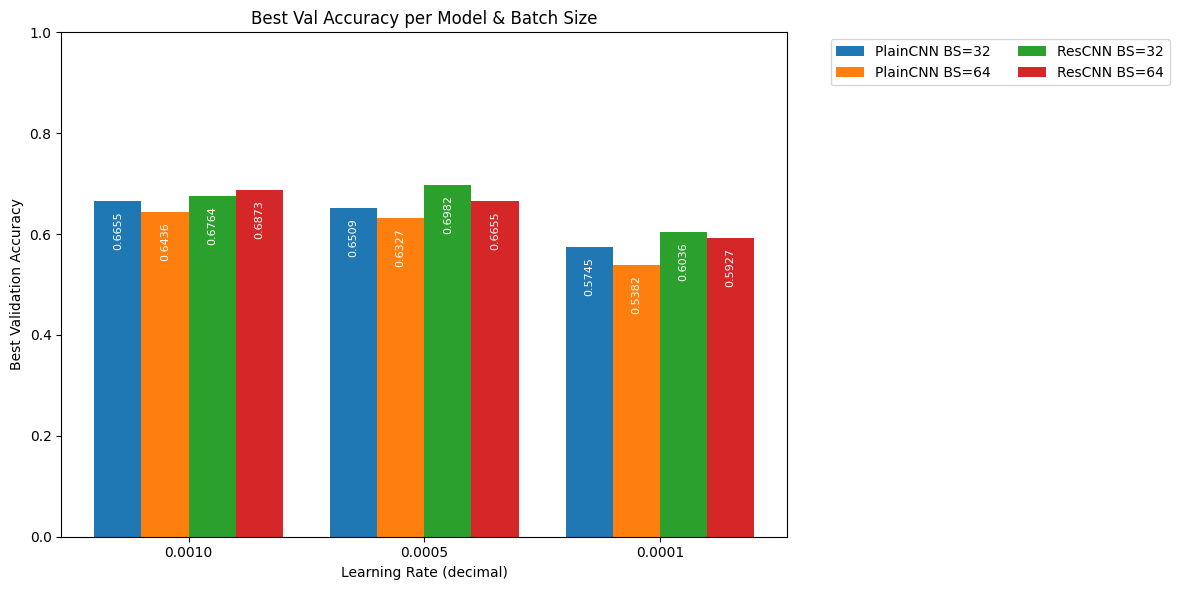

In [16]:
labels = [f"{lr:.4f}" for lr in LEARNING_RATES]
x      = np.arange(len(labels))

n_models   = 2
n_batches  = len(BATCH_SIZES)
total_bars = n_models * n_batches
width      = 0.8 / total_bars

# 3) Plot
plt.figure(figsize=(12, 6))

for i, model_name in enumerate(['PlainCNN','ResCNN']):
    for j, bs in enumerate(BATCH_SIZES):

        
        best_vals = [
            max(history[(model_name, bs, lr)]['val_accs'])
            for lr in LEARNING_RATES
        ]

        
        offset = (i * n_batches + j - (total_bars - 1) / 2) * width

        bars = plt.bar(x + offset, best_vals, width, label=f"{model_name} BS={bs}")

        for bar in bars:
            h = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2,  
                h - 0.02,                          
                f"{h:.4f}",                       
                rotation=90,                      
                ha='center', va='top',
                fontsize=8, color='white'
            )

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel("Learning Rate (decimal)")
plt.ylabel("Best Validation Accuracy")
plt.title("Best Val Accuracy per Model & Batch Size")
plt.legend(ncol=2, bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()



### 9. PLOT #2: EPOCH-WISE CURVES (3 per model ⇒ total 6)

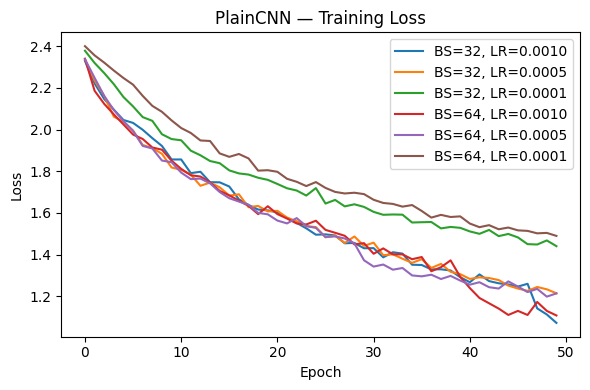

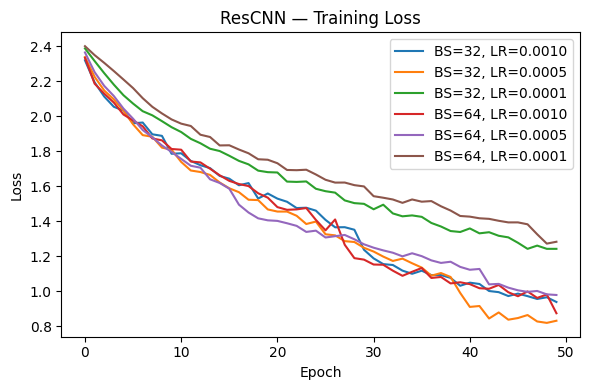

In [18]:
for model_name in ['PlainCNN','ResCNN']:
    plt.figure(figsize=(6,4))
    for (m, bs, lr), h in history.items():
        if m != model_name:
            continue
        plt.plot(h['train_losses'], label=f"BS={bs}, LR={lr:.4f}")
    plt.title(f"{model_name} — Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

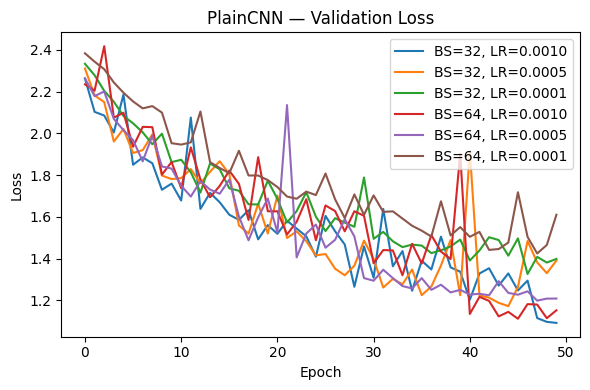

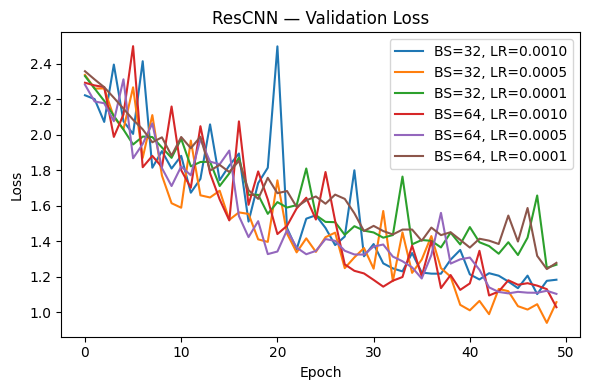

In [19]:
for model_name in ['PlainCNN','ResCNN']:
    plt.figure(figsize=(6,4))
    for (m, bs, lr), h in history.items():
        if m != model_name:
            continue
        plt.plot(h['val_losses'], label=f"BS={bs}, LR={lr:.4f}")
    plt.title(f"{model_name} — Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

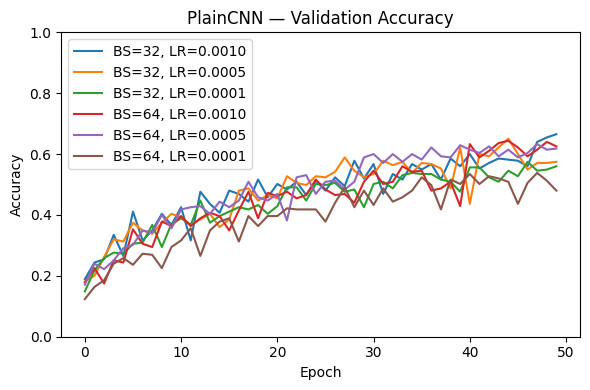

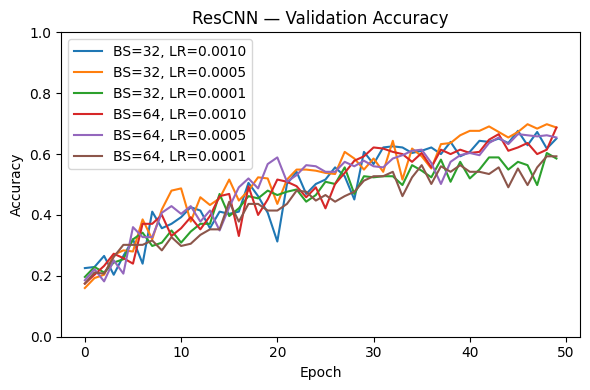

In [20]:
for model_name in ['PlainCNN','ResCNN']:
    plt.figure(figsize=(6,4))
    for (m, bs, lr), h in history.items():
        if m != model_name:
            continue
        plt.plot(h['val_accs'], label=f"BS={bs}, LR={lr:.4f}")
    plt.title(f"{model_name} — Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 10. PLOT #3: CONFUSION MATRICES FOR BEST (inc. dropout)

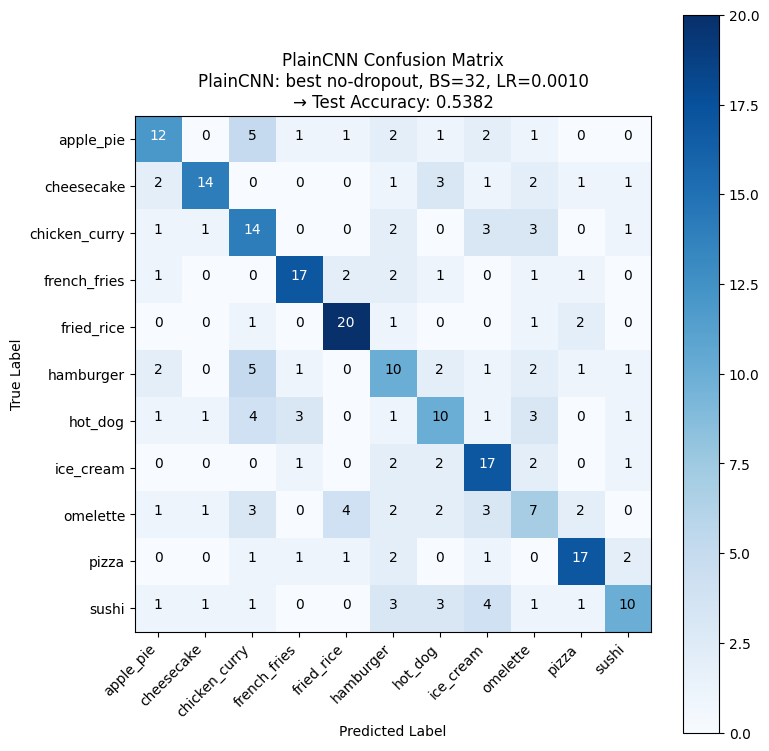

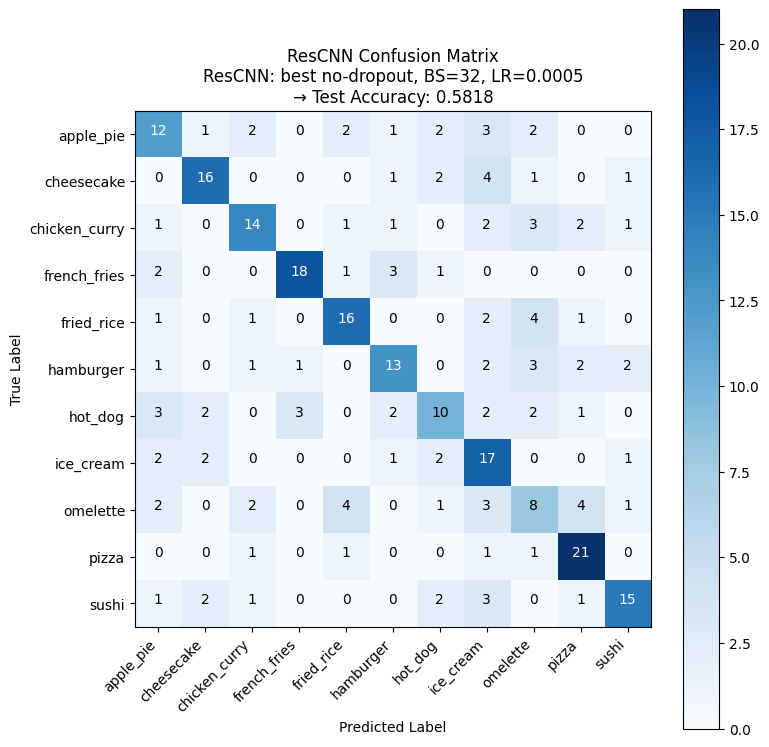

In [25]:
classes = datasets.ImageFolder(os.path.join(DATA_DIR, "train")).classes

for name in ['PlainCNN', 'ResCNN']:
    # 1) Determine best overall model
    no_cfg    = results_no_dropout[name]
    drop_dict = results_with_dropout[name]
    p_best, db = max(drop_dict.items(), key=lambda kv: kv[1]['val_acc'])

    if db['val_acc'] > no_cfg['val_acc']:
        dropout_val = p_best
        chosen      = db
        cfg_text    = f"best with dropout={dropout_val}"
    else:
        dropout_val = 0.0
        chosen      = no_cfg
        cfg_text    = "best no-dropout"

    bs        = best_cfg[name]['bs']
    lr        = best_cfg[name]['lr']
    test_acc  = chosen['test_acc']

    # 2) Load the model
    m = model_map[name](dropout_prob=dropout_val).to(device)
    m.load_state_dict(chosen['state_dict'])

    # 3) Gather predictions & labels
    _, _, test_loader = get_loaders(bs)
    all_preds, all_labels = [], []
    m.eval()
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs = imgs.to(device)
            preds = m(imgs).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labs.numpy())

    # 4) Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # 5) Plot with config & test-acc in the title, and annotated cells
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    title_str = (
        f"{name} Confusion Matrix\n"
        f"{name}: {cfg_text}, BS={bs}, LR={lr:.4f}\n"
        f"→ Test Accuracy: {test_acc:.4f}"
    )
    plt.title(title_str)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, f"{cm[i, j]}",
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


### 11. PLOT #4: BAR CHARTS ― val vs test (no-drop vs drop=0.3 vs drop=0.5)

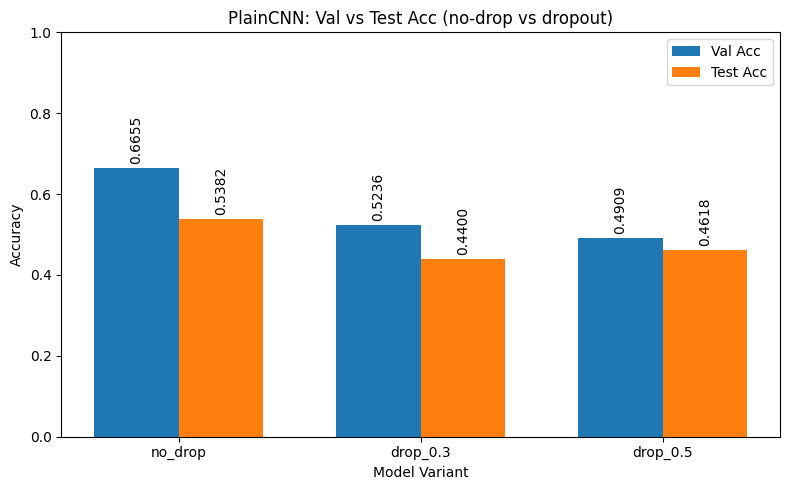

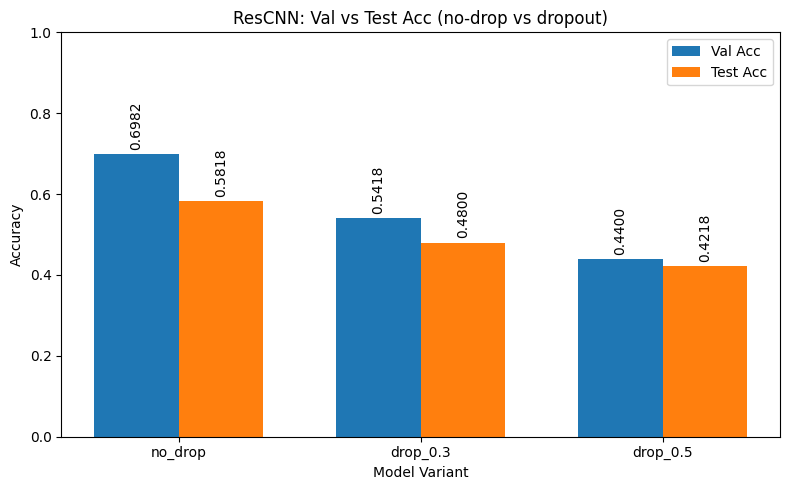

In [27]:
for name in ['PlainCNN','ResCNN']:
    no   = results_no_dropout[name]
    ds   = results_with_dropout[name]
    ps   = sorted(ds.keys())
    labels = ['no_drop'] + [f"drop_{p}" for p in ps]
    vals    = [no['val_acc']] + [ds[p]['val_acc'] for p in ps]
    tests   = [no['test_acc']] + [ds[p]['test_acc'] for p in ps]

    x     = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8,5))
    bars1 = plt.bar(x - width/2, vals,  width, label='Val Acc')
    bars2 = plt.bar(x + width/2, tests, width, label='Test Acc')

    # annotate each bar with its value, rotated vertically
    for bar in list(bars1) + list(bars2):
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,  # bar center on x-axis
            h + 0.01,                         # just above the bar
            f"{h:.4f}",                      # the value
            ha='center', va='bottom',
            rotation=90                       # vertical text
        )

    plt.xticks(x, labels)
    plt.ylim(0, 1)
    plt.xlabel("Model Variant")
    plt.ylabel("Accuracy")
    plt.title(f"{name}: Val vs Test Acc (no‐drop vs dropout)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# PART 2 – TRANSFER LEARNING WITH MobileNetV2
# -----------------------------------------------------------------------------

# 1) IMPORTS & SETUP
# -----------------------------------------------------------------------------

In [7]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets

# Hyperparameters
BATCH_SIZE      = 32
EPOCHS          = 50
WEIGHT_DECAY    = 5e-5
LRS             = {'fc_only': 1e-3, 'last2+fc': 5e-4}

# -----------------------------------------------------------------------------
# 2) Preliminary preparations and training part
# -----------------------------------------------------------------------------

In [8]:
train_loader, val_loader, test_loader = get_loaders(BATCH_SIZE)

criterion = nn.CrossEntropyLoss()

classes = datasets.ImageFolder(os.path.join(DATA_DIR, "train")).classes

### 2.1) CASE A: train only FC

In [11]:
# 1) Load pre‐trained MobileNetV2
weights = models.MobileNet_V2_Weights.DEFAULT
model_fc = models.mobilenet_v2(weights=weights).to(device)

# 2) Freeze all params
for p in model_fc.parameters():
    p.requires_grad = False

# 3) Re‐shape the existing FC head to output NUM_CLASSES
in_feats               = model_fc.classifier[1].in_features
model_fc.classifier[1] = nn.Linear(in_feats, NUM_CLASSES).to(device)

for p in model_fc.classifier[1].parameters():
    p.requires_grad = True

# 5) Optimizer over only that layer
optimizer_fc = optim.Adam(
    model_fc.classifier[1].parameters(),
    lr=LRS['fc_only'],
    weight_decay=WEIGHT_DECAY
)

best_val_fc, best_w_fc = 0.0, None
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model_fc, train_loader, criterion, optimizer_fc)
    va_loss, va_acc = eval_epoch(model_fc,   val_loader,   criterion)
    if va_acc > best_val_fc:
        best_val_fc, best_w_fc = va_acc, copy.deepcopy(model_fc.state_dict())
    if ep % 10 == 0:
        print(f"[FC-only] Ep{ep:02d} — tr_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")

# 7) Evaluate on test
model_fc.load_state_dict(best_w_fc)
te_loss_fc, te_acc_fc = eval_epoch(model_fc, test_loader, criterion)
print(f"\n→ FC-only: best_val_acc={best_val_fc:.4f}, test_acc={te_acc_fc:.4f}\n")

[FC-only] Ep10 — tr_acc=0.7355, val_acc=0.8109


[FC-only] Ep20 — tr_acc=0.7714, val_acc=0.7964


[FC-only] Ep30 — tr_acc=0.7609, val_acc=0.8073


[FC-only] Ep40 — tr_acc=0.7895, val_acc=0.8109


[FC-only] Ep50 — tr_acc=0.7886, val_acc=0.8218

→ FC-only: best_val_acc=0.8291, test_acc=0.7382



# 2.2) CASE B: train last two conv + FC

In [12]:
# 1) Reload fresh pre‐trained model
model_ft = models.mobilenet_v2(weights=weights).to(device)
for p in model_ft.parameters():
    p.requires_grad = False

# 2) Unfreeze the last two convolutional blocks

for block in model_ft.features[-2:]:
    for p in block.parameters():
        p.requires_grad = True

in_feats                = model_ft.classifier[1].in_features
model_ft.classifier[1]  = nn.Linear(in_feats, NUM_CLASSES).to(device)
for p in model_ft.classifier[1].parameters():
    p.requires_grad = True

# 4) Optimizer over all params needing grad
optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=LRS['last2+fc'],
    weight_decay=WEIGHT_DECAY
)

# 5) Training loop
best_val_ft, best_w_ft = 0.0, None
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model_ft, train_loader, criterion, optimizer_ft)
    va_loss, va_acc = eval_epoch(model_ft,   val_loader,   criterion)
    if va_acc > best_val_ft:
        best_val_ft, best_w_ft = va_acc, copy.deepcopy(model_ft.state_dict())
    if ep % 10 == 0:
        print(f"[last2+FC] Ep{ep:02d} — tr_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")

# 6) Evaluate on test
model_ft.load_state_dict(best_w_ft)
te_loss_ft, te_acc_ft = eval_epoch(model_ft, test_loader, criterion)
print(f"\n→ last2+FC: best_val_acc={best_val_ft:.4f}, test_acc={te_acc_ft:.4f}\n")


[last2+FC] Ep10 — tr_acc=0.9191, val_acc=0.8400


[last2+FC] Ep20 — tr_acc=0.9605, val_acc=0.8545


[last2+FC] Ep30 — tr_acc=0.9686, val_acc=0.8545


[last2+FC] Ep40 — tr_acc=0.9800, val_acc=0.8473


[last2+FC] Ep50 — tr_acc=0.9686, val_acc=0.8655

→ last2+FC: best_val_acc=0.8836, test_acc=0.7455



# -----------------------------------------------------------------------------
# 4) PLOT CONFUSION MATRIX FOR BEST TRANSFER MODEL
# -----------------------------------------------------------------------------

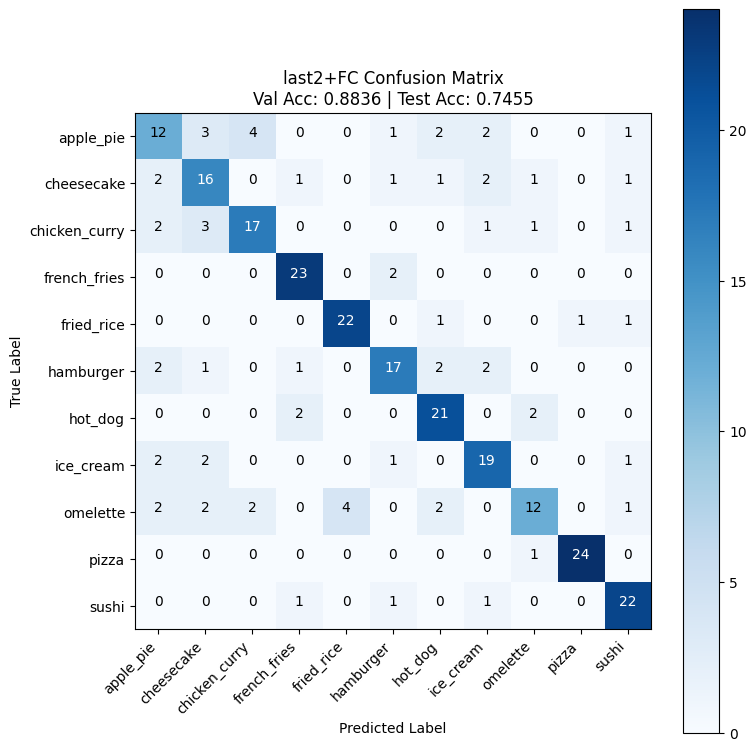

In [16]:
if best_val_fc >= best_val_ft:
    best_model = model_fc
    model_name = "FC-only"
    val_acc     = best_val_fc
    test_acc    = te_acc_fc
else:
    best_model = model_ft
    model_name = "last2+FC"
    val_acc     = best_val_ft
    test_acc    = te_acc_ft

# Gather all predictions & true labels
all_preds, all_trues = [], []
best_model.eval()
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        preds = best_model(imgs).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_trues.extend(labs.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_trues, all_preds)

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
title_str = (
    f"{model_name} Confusion Matrix\n"
    f"Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}"
)
plt.title(title_str)
plt.colorbar()

tick_marks = range(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i, f"{cm[i, j]}",
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black'
    )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()